# 6.1 Preprocess department 11-00091 (Boston, MA)

This is a prototype for preprocessing Boston's Field Interviews data file.

In [51]:
import numpy
import pandas

from cpe_help import Department

In [7]:
dept = Department('11-00091')
path = dept.tabular_input_dir / '11-00091_Field-Interviews_2011-2015.csv'
df = pandas.read_csv(path, skiprows=[1], low_memory=False)

In [23]:
df.shape

(152230, 34)

In [17]:
df.head().T

,0,1,2,3,4
INCIDENT_UNIQUE_IDENTIFIER,938283,881897,882060,971623,882761
INCIDENT_UNIQUE_IDENTIFIER.1,621880,565177,565340,653895,566043
SUBJECT_GENDER,MALE,MALE,MALE,MALE,MALE
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,NORMANDY ST at SUPPLE RD,75 BOYLSTON ST,5 TOPLIFF ST,170 MORTON ST,0 ST ALPHONSUS ST
LOCATION_DISTRICT,B2,A1,C11,B2,B2
LOCATION_DISTRICT.1,3,1,5,3,3
INCIDENT_DATE,12/10/13 0:00,5/24/12 0:00,6/4/12 0:00,6/21/14 0:00,12/2/10 0:00
INCIDENT_TIME,12/10/13 0:00,5/24/12 0:00,6/4/12 0:00,6/21/14 0:00,12/2/10 0:00
SUBJECT_DETAILS,YES,NO,YES,YES,YES
SUBJECT_RACE,B(Black),W(White),B(Black),B(Black),B(Black)


# Date and time

In [18]:
date = df['INCIDENT_DATE']
time = df['INCIDENT_TIME']

In [20]:
(date == time).all()

True

`INCIDENT_DATE` and `INCIDENT_TIME` columns are the same. We can use only one.

In [21]:
del time

In [22]:
date.head()

0    12/10/13 0:00
1     5/24/12 0:00
2      6/4/12 0:00
3     6/21/14 0:00
4     12/2/10 0:00
Name: INCIDENT_DATE, dtype: object

First try:

In [29]:
fdate = pandas.to_datetime(date, format='%m/%d/%y %H:%M')

In [30]:
fdate.describe()

count                  152230
unique                   2140
top       2014-04-25 00:00:00
freq                      222
first     1969-07-26 00:00:00
last      2067-11-11 00:00:00
Name: INCIDENT_DATE, dtype: object

Now, wtf, didn't we just have data from 2011 to 2015?

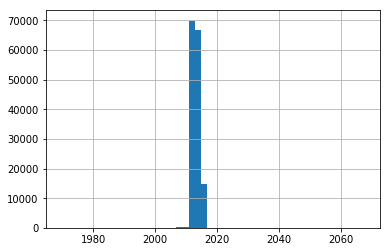

In [33]:
fdate.hist(bins=50)

In [45]:
fdate.dt.year.value_counts().head(20)

2012    38703
2011    35227
2014    33981
2013    33370
2015     9494
2010      922
2008      207
2007      161
2009       43
2006       19
2018       11
2003        9
2004        9
2016        6
2017        6
1993        5
2021        4
2002        3
1990        3
1989        3
Name: INCIDENT_DATE, dtype: int64

2020 is not a possible year right now. It must be data from 1920 or an error in the data. If it's not an error, it's a problem because, for example, we can't know if the following entries are from 1913 or 2013:

In [46]:
date[fdate.dt.year == 2013].head()

0    12/10/13 0:00
6      8/3/13 0:00
7     8/31/13 0:00
8     8/31/13 0:00
9     8/31/13 0:00
Name: INCIDENT_DATE, dtype: object

I believe that these entries are really interviews from the past that were somehow registered, seeing that the most common year after 2011-2015 is 2010. A similar trend follows.

Given that we won't lose too much data if we drop these past years, let's do it!

In [49]:
year = fdate.dt.year
date_inferred = (year >= 2011) & (year <= 2015)
date_inferred.head()

0     True
1     True
2     True
3     True
4    False
Name: INCIDENT_DATE, dtype: bool

In [50]:
date_inferred.mean()

# may also call INCIDENT_DATED

0.9904420941995664

Now to the dataframe:

In [52]:
df = df.drop(['INCIDENT_DATE', 'INCIDENT_TIME'], axis=1)
df['INCIDENT_DATED'] = date_inferred
df['INCIDENT_DATE'] = fdate.where(date_inferred, other=numpy.nan)

In [57]:
df.INCIDENT_DATED.mean()

0.9904420941995664

In [56]:
df.INCIDENT_DATE.notnull().mean()

0.9904420941995664

In [59]:
df['INCIDENT_DATE'].describe()

count                  150775
unique                   1668
top       2014-04-25 00:00:00
freq                      222
first     2011-01-01 00:00:00
last      2015-12-31 00:00:00
Name: INCIDENT_DATE, dtype: object

In [61]:
df['INCIDENT_DATE'].dt.year.value_counts()

2012.0    38703
2011.0    35227
2014.0    33981
2013.0    33370
2015.0     9494
Name: INCIDENT_DATE, dtype: int64

One weird thing is why there are so few entries for 2015.

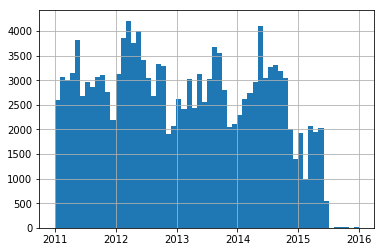

In [62]:
df['INCIDENT_DATE'].hist(bins=60)

That's because the data is cut at a certain point. Let's find it, or, only use data until 2014.

In [65]:
fdate[fdate.dt.year == 2014].dt.month.value_counts().sort_index()

1     2316
2     2431
3     2774
4     2934
5     4083
6     3071
7     3363
8     3299
9     3194
10    3035
11    2005
12    1476
Name: INCIDENT_DATE, dtype: int64

In [64]:
fdate[fdate.dt.year == 2015].dt.month.value_counts().sort_index()

1     1898
2      894
3     2037
4     1975
5     2066
6      577
7        7
8       10
9        9
10       8
11       5
12       8
Name: INCIDENT_DATE, dtype: int64

In [66]:
Department('49-00081').full_name

'49-00081 (San Francisco, CA)'

The drop in interviews in February seems to have been caused by a [winter][1]. I think the data collection stopped mid June, so let's use data until May.

Interestingly enough, department 49-00081 (San Francisco, CA) also has a table that goes until May, 2015. This may be a date when CPE retrieved some of the data.

[1]: https://en.wikipedia.org/wiki/2014%E2%80%9315_North_American_winter#Mid-February_blizzard

Clean:

In [77]:
dept = Department('11-00091')
path = dept.tabular_input_dir / '11-00091_Field-Interviews_2011-2015.csv'
df = pandas.read_csv(path, skiprows=[1], low_memory=False)

In [78]:
date = df['INCIDENT_DATE']
fdate = pandas.to_datetime(date, format='%m/%d/%y %H:%M')

In [79]:
date_min = pandas.to_datetime('2011-01-01')
date_max = pandas.to_datetime('2015-05-31')

date_inferred = (fdate >= date_min) & (fdate <= date_max)

In [80]:
df = df.drop(['INCIDENT_DATE', 'INCIDENT_TIME'], axis=1)
df['INCIDENT_DATED'] = date_inferred
df['INCIDENT_DATE'] = fdate.where(date_inferred)

In [81]:
df['INCIDENT_DATED'].mean()

0.986343033567628

In [82]:
df['INCIDENT_DATE'].notnull().mean()

0.986343033567628

In [85]:
df['INCIDENT_DATE'].describe()

count                  150151
unique                   1612
top       2014-04-25 00:00:00
freq                      222
first     2011-01-01 00:00:00
last      2015-05-31 00:00:00
Name: INCIDENT_DATE, dtype: object

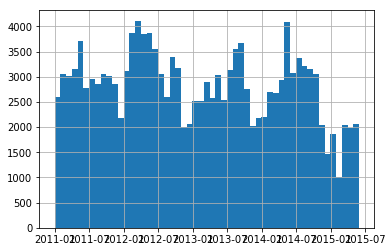

In [84]:
df['INCIDENT_DATE'].hist(bins=12*4+5);

# Location

The only available LOCATION parameters are the following:

In [87]:
df[[c for c in df if c.startswith('LOCATION')]].head()

,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,LOCATION_STREET_NUMBER,LOCATION_CITY
0,NORMANDY ST at SUPPLE RD,B2,3,3274,NO DATA ENTERED
1,75 BOYLSTON ST,A1,1,543,OTHER
2,5 TOPLIFF ST,C11,5,4493,NO DATA ENTERED
3,170 MORTON ST,B2,3,3094,Dorchester
4,0 ST ALPHONSUS ST,B2,3,4241,Dorchester


With 152230 entries we will probably use batch requests.

Running times:

- 1 RPS (Request Per Second):  42h17m
- 5 RPS (Request Per Second):  8h27m
- 20 RPS (Request Per Second): 2h7m
- 50 RPS (Request Per Second): 51m

In [95]:
pandas.Timedelta(seconds=152230 / 50)

Timedelta('0 days 00:50:44.600000')

In [91]:
24 + 18

42

In [88]:
df.shape

(152230, 34)

I believe that with the address and number (also a bit of the city), it is possible to retrieve the coordinates. The process will be prone to errors, though, and we should use a service.

Libraries:

- https://github.com/DenisCarriere/geocoder
- https://github.com/geopy/geopy